In [1]:
import pandas as pd
import numpy as np

# Load data
csv_file_path = '/Users/balmeru/Downloads/1986.csv' 
df = pd.read_csv(csv_file_path)

columns_to_check = ['ajexdi', 'prccd', 'trfd']
df.dropna(subset=columns_to_check, how='any', inplace=True)

date_format = '%Y-%m-%d'  
df['datadate'] = pd.to_datetime(df['datadate'], format=date_format)
df.sort_values(by=['tic', 'datadate'], inplace=True)

df['adjusted_close'] = df['prccd'] / df['ajexdi']
df['adjusted_close_prior'] = df.groupby('tic')['adjusted_close'].shift(1)
df['trfd_prior'] = df.groupby('tic')['trfd'].shift(1)

df['daily_return'] = (
    ((df['adjusted_close'] * df['trfd']) /
     (df['adjusted_close_prior'] * df['trfd_prior'])) - 1
) * 100

df['day_diff'] = df.groupby('tic')['datadate'].diff().dt.days 
df.loc[df['day_diff'] > 5, 'daily_return'] = np.nan

pivot_df = df.pivot_table(index='datadate', columns='tic', values='daily_return')

pivot_df1 = pivot_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = pivot_df1.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_1986.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_1986.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  2185B  3219B  3234B  3557B  3614B  3899B  \
1985-12-09   5.26  -7.35   3.00    NaN    NaN   2.38    NaN   5.05    NaN   
1985-12-16   0.00  -4.76   0.97    NaN    NaN  -3.49    NaN   1.27    NaN   
1985-12-23   0.63  -1.67  -0.00    NaN    NaN  10.84    NaN  -4.14    NaN   
1985-12-30  -0.62  13.56   2.88    NaN    NaN  -3.26    NaN   6.33    NaN   
1986-01-06  -2.50   1.49   3.74    NaN    NaN  -5.62    NaN   2.73    NaN   
1986-01-13   3.85  -1.47   0.00    NaN    NaN   4.76    NaN  -0.97    NaN   
1986-01-20  -0.62  -4.48   1.80    NaN    NaN  -2.27    NaN  -3.17    NaN   
1986-01-27   2.48   0.00   4.42    NaN    NaN  13.95    NaN  -0.00    NaN   
1986-02-03   2.42   4.69  -0.85    NaN    NaN -10.20    NaN  -3.78    NaN   
1986-02-10  -1.18  -1.49   1.71    NaN    NaN   2.84    NaN   7.85    NaN   

tic         3ACDGE  ...  ZIGO  ZIM.1  ZING.1  ZION   ZMX   ZNT 

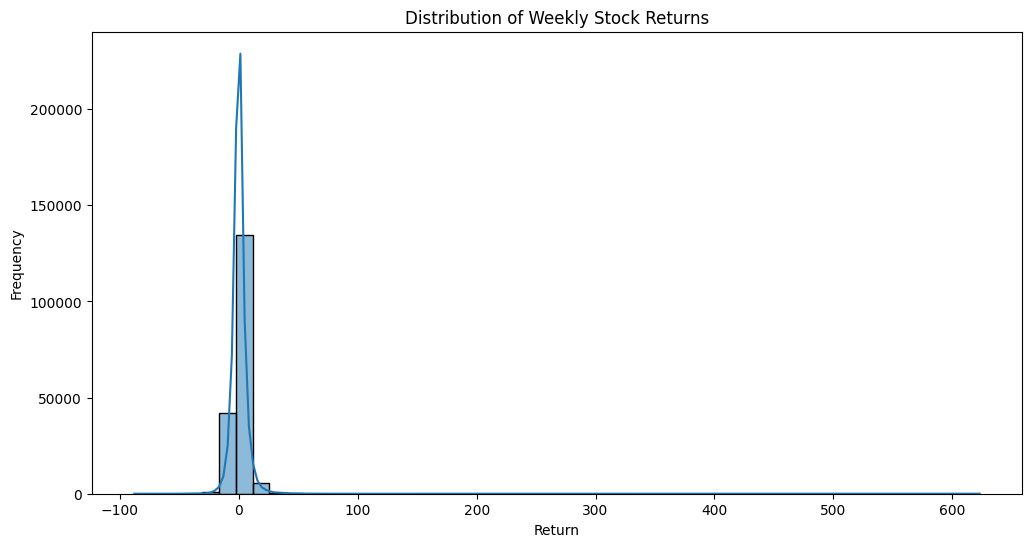

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
stacked_returns = weekly_pivot_df.stack()

plt.figure(figsize=(12, 6))
sns.histplot(stacked_returns, bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()



In [3]:
stacked_returns.describe()

count   183985.00
mean         0.30
std          6.57
min        -88.08
25%         -2.49
50%          0.00
75%          2.60
max        623.14
dtype: float64

In [7]:
# Calculate mean and standard deviation of daily returns
mean_daily_return = pivot_df.mean()
std_daily_return = pivot_df.std()

# Define upper and lower bounds for outliers based on mean ± 3 standard deviations
upper_bound = mean_daily_return + 3 * std_daily_return
lower_bound = mean_daily_return - 3 * std_daily_return

# Identify outliers using mean ± 3 standard deviations approach
outliers_mean_3sd = (pivot_df > upper_bound) | (pivot_df < lower_bound)

# Count number of outliers and total data points
num_outliers_mean_3sd = outliers_mean_3sd.sum().sum()
total_data_points = pivot_df.notnull().sum().sum()

# Print results
print(f"Number of outliers using mean ± 3 standard deviations approach: {num_outliers_mean_3sd}")
print(f"Total number of data points: {total_data_points}")

# Now you can repeat the process for MAD approach


Number of outliers using mean ± 3 standard deviations approach: 12154
Total number of data points: 895183


In [17]:
mean = pivot_df.mean()
std = pivot_df.std()

num_std = 3
lower_bound = mean - num_std * std
upper_bound = mean + num_std * std

outliers_removed_df = pivot_df[(pivot_df >= lower_bound) & (pivot_df <= upper_bound)]


In [11]:


outliers_removed_df = outliers_removed_df.map(lambda x: x / 100 if pd.notnull(x) else np.nan)

adjusted_daily_returns = outliers_removed_df.map(lambda x: x + 1 if pd.notnull(x) else np.nan)

def consecutive_zeros(prices):
    count = 0
    max_count = 0
    for price in prices:
        if price == 0:
            count += 1
            max_count = max(max_count, count) 
        else:
            count = 0
    return max_count

consecutive_zero_counts = df.groupby('tic')['prccd'].apply(consecutive_zeros)

for ticker, max_zeros in consecutive_zero_counts.items():
    if max_zeros > 5:
        warnings.warn(f"Warning: Ticker '{ticker}' has more than 5 consecutive zeros in 'prccd'.")

all_weekdays = pd.date_range(start=adjusted_daily_returns.index.min(), end=adjusted_daily_returns.index.max(), freq='B')  
df_reindexed = adjusted_daily_returns.reindex(all_weekdays)

all_mondays = pd.date_range(start=df_reindexed.index.min(), end=df_reindexed.index.max(), freq='W-MON')
weekly_pivot_df = pd.DataFrame(data=np.nan, index=all_mondays, columns=df_reindexed.columns)
ticker_start_dates = df_reindexed.apply(lambda x: x.first_valid_index(), axis=0)

for i, monday in enumerate(all_mondays):
    start_date = monday
    if i < len(all_mondays) - 1:
        end_date = all_mondays[i + 1] - pd.DateOffset(days=1)
    else:
        end_date = df_reindexed.index.max()  # Last Monday
    
    weekly_data = df_reindexed.loc[start_date:end_date]
    for ticker in df_reindexed.columns:
        if monday < ticker_start_dates[ticker]:
            weekly_pivot_df.loc[monday, ticker] = np.nan
        else:
            if weekly_data.isnull().sum(axis=0)[ticker] == 5:
                weekly_pivot_df.loc[monday, ticker] = np.nan
            else:
                weekly_pivot_df.loc[monday, ticker] = (weekly_data[ticker].prod(skipna=True) - 1) * 100

pd.set_option('display.float_format', lambda x: f'{x:.2f}')  

weekly_pivot_path = "weekly_1986.csv"  
weekly_pivot_df.to_csv(weekly_pivot_path)
print(f"Weekly Pivot Table saved to: {weekly_pivot_path}")
print("Weekly Returns Pivot Table (first 10 rows):")
print(weekly_pivot_df.head(10))


Weekly Pivot Table saved to: weekly_1986.csv
Weekly Returns Pivot Table (first 10 rows):
tic         0223B  0485B  0491B  2185B  3219B  3234B  3557B  3614B  3899B  \
1985-12-09   5.26  -7.35   3.00    NaN    NaN   2.38    NaN   5.05    NaN   
1985-12-16   0.00  -4.76   0.97    NaN    NaN  -3.49    NaN   1.27    NaN   
1985-12-23   0.63  -1.67  -0.00    NaN    NaN  10.84    NaN  -4.14    NaN   
1985-12-30  -0.62  13.56   2.88    NaN    NaN  -3.26    NaN   1.00    NaN   
1986-01-06  -2.50   1.49  -4.31    NaN    NaN  -5.62    NaN   2.73    NaN   
1986-01-13   3.85  -1.47   0.00    NaN    NaN   4.76    NaN  -0.97    NaN   
1986-01-20  -0.62  -4.48   1.80    NaN    NaN  -2.27    NaN  -3.17    NaN   
1986-01-27   2.48   0.00   4.42    NaN    NaN  13.95    NaN  -0.00    NaN   
1986-02-03   2.42   4.69  -0.85    NaN    NaN -10.20    NaN  -3.78    NaN   
1986-02-10  -1.18  -1.49   1.71    NaN    NaN   2.84    NaN   7.85    NaN   

tic         3ACDGE  ...  ZIGO  ZIM.1  ZING.1  ZION   ZMX   ZNT 

In [12]:
weekly_pivot_df.stack().describe()

count   183973.00
mean         0.06
std          5.12
min        -95.24
25%         -2.44
50%          0.00
75%          2.34
max        113.22
dtype: float64

In [14]:
#filtering daily return outliers with +-3st dev from mean only reduced weekly returns from
#count 183985 to 183973 by 12 data points only

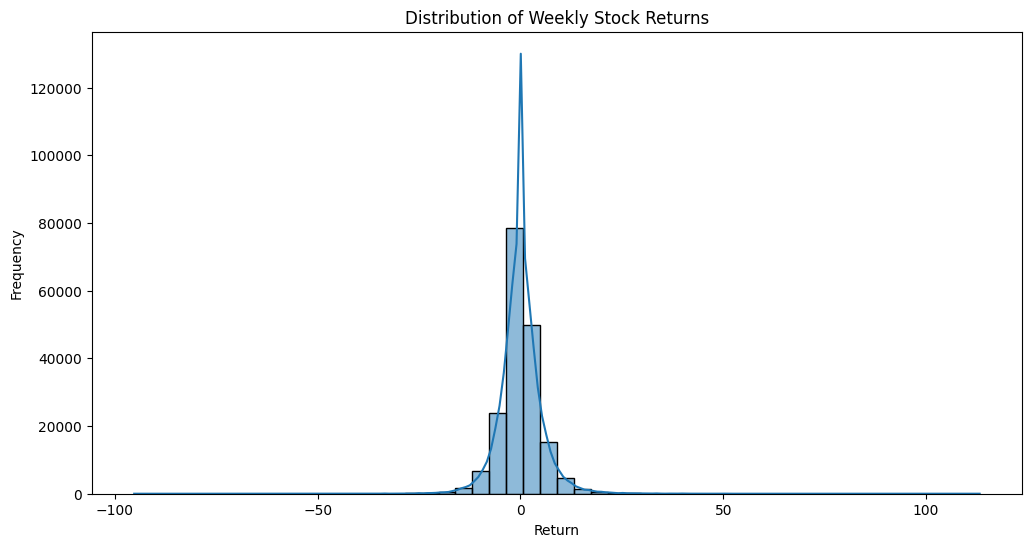

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plot = weekly_pivot_df.stack()

plt.figure(figsize=(12, 6))
sns.histplot(plot, bins=50, kde=True)
plt.title('Distribution of Weekly Stock Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()
